In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *


# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_2nuBB_slim.h5","hits")

# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_4mm_smear.h5',"MC/hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear.h5","hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear_1mmbin.h5","hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_1mmstep_high_E_slim_smear.h5","hits")


# hits = pd.read_hdf("../data/ATPC_gamma/ATPC_gamma_SF0_779551_24.h5", "hits")

# hits = pd.read_hdf("../../NEXT_nudobe/files/data/mbb_0_1mm_smear.h5", "MC/hits")

hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_smear.h5", "MC/hits")


# hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_SF0_779552_232.h5", "hits")

display(hits)


,event_id,x,y,z,energy
0,500,2712.937500,561.145691,3449.367920,0.007000
1,500,2711.868652,549.636658,3449.524902,0.002800
2,500,2709.237061,570.507812,3450.609131,0.004200
3,500,2712.186768,540.319641,3451.921143,0.005975
4,500,2706.395020,577.820129,3453.869141,0.002625
...,...,...,...,...,...
12162,523,-847.445984,-2051.975586,2370.962891,0.011800
12163,523,-844.905029,-2069.626465,2371.674072,0.002250
12164,523,-845.406250,-2069.704834,2371.686035,0.014625
12165,523,-846.071289,-2057.985352,2373.768066,0.009200


,event_id,x,y,z,energy
0,523,-2067.318359,-2550.580811,2210.513672,0.019600
1,523,-2066.539307,-2555.883789,2213.031494,0.000500
2,523,-2060.906494,-2547.427490,2208.802002,0.001925
3,523,-2059.325195,-2558.895996,2213.308105,0.010050
4,523,-2056.952393,-2560.934082,2216.211670,0.033850
...,...,...,...,...,...
518,523,-844.000549,-2046.552368,2365.756836,0.006600
519,523,-843.564758,-2025.651123,2291.000977,0.002100
520,523,-843.361938,-2045.263794,2364.316162,0.002525
521,523,-843.314453,-2014.473022,2293.152832,0.000625


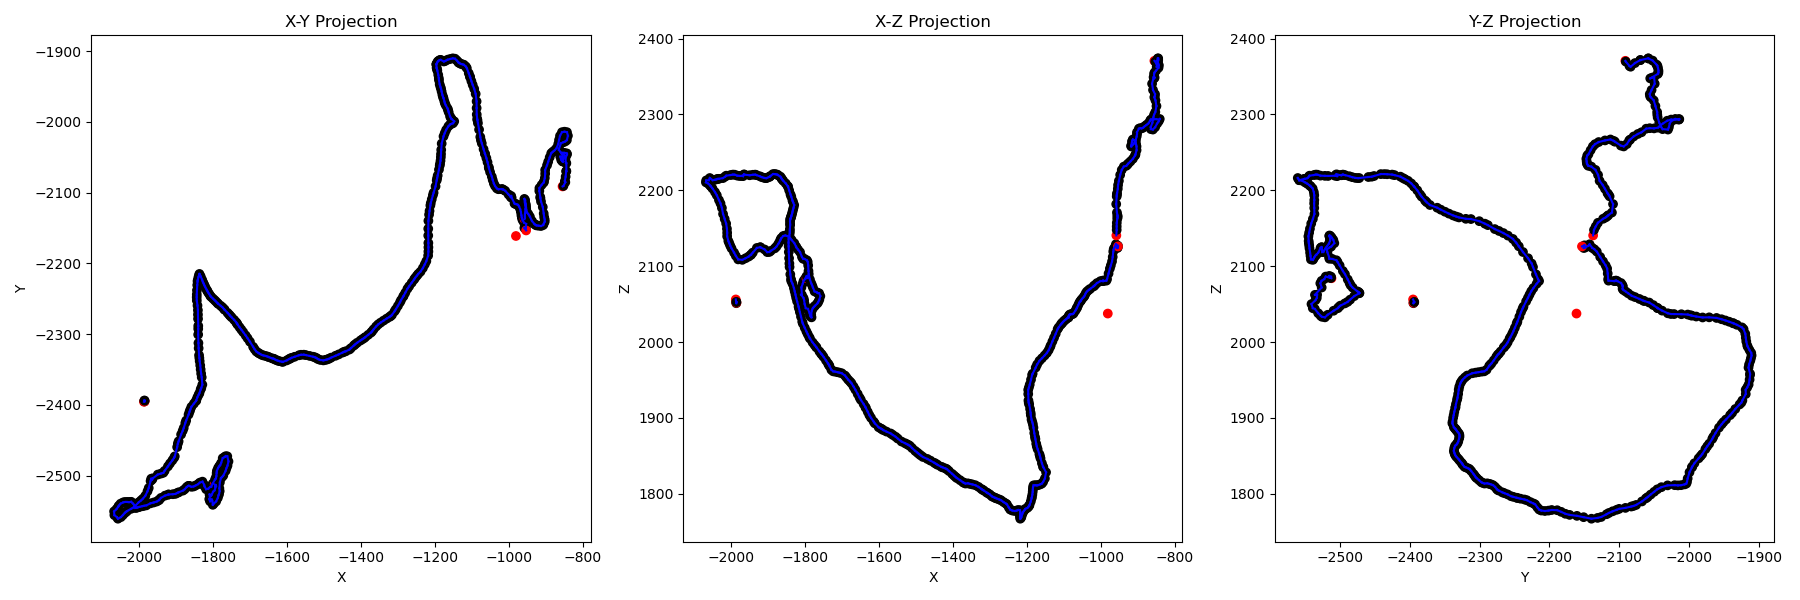

In [2]:
%matplotlib widget

data = hits[hits.event_id ==523]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
# eid = data.event_id.item()
data = data[['event_id', 'x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}
connections = []

# Tunable parameters
init_dist_thresh = 15 # max distance for initial connections [mm]
incr_dist_thresh = [2,4,6,8,10,12,14,16,18,20] # Second stage, look for closest nodes, then slowly increase threshold [mm]
dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]


for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break




# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

{'id': 0, 'start': 36, 'end': 39, 'nodes': [36, 37, 40, 38, 39], 'length': 7.476, 'energy': 0.053699999290984124, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}
{'id': 2, 'start': 162, 'end': 444, 'nodes': [162, 165, 166, 164, 169, 161, 158, 153, 150, 145, 146, 144, 152, 154, 156, 159, 170, 175, 178, 179, 182, 181, 183, 186, 188, 191, 195, 197, 199, 201, 198, 196, 194, 190, 187, 184, 180, 176, 173, 172, 171, 168, 163, 155, 151, 147, 142, 138, 136, 134, 131, 121, 106, 92, 90, 88, 85, 84, 82, 81, 78, 76, 73, 70, 68, 65, 62, 61, 59, 55, 54, 53, 51, 50, 45, 42, 35, 33, 31, 29, 28, 27, 25, 26, 24, 22, 20, 19, 17, 16, 15, 12, 10, 7, 6, 5, 2, 0, 1, 3, 4, 8, 9, 11, 13, 14, 18, 21, 23, 30, 32, 34, 41, 43, 44, 46, 47, 48, 49, 52, 56, 57, 58, 60, 63, 64, 66, 67, 69, 71, 72, 74, 75, 77, 79, 80, 83, 86, 87, 89, 91, 93, 94, 100, 113, 119, 123, 127, 130, 128, 126, 124, 122, 120, 117, 115, 114, 111, 108, 109, 110, 107, 105, 104, 101, 97, 95, 96, 98, 99, 102, 103,

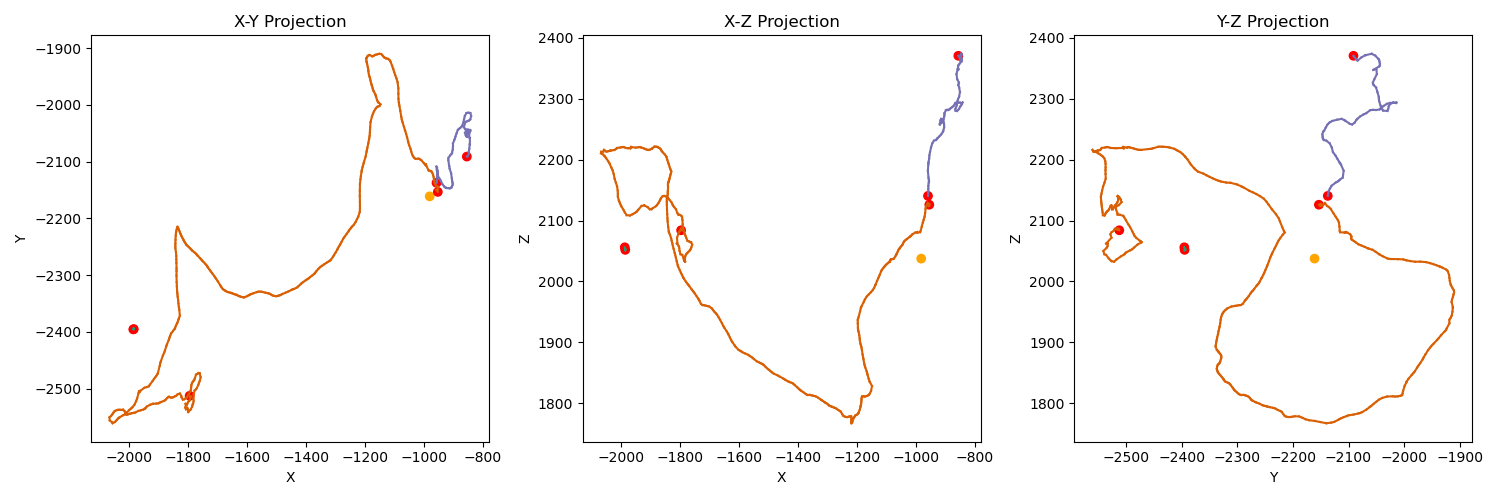

In [3]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [4]:
print(GetMeanNodeDist(Tracks, data))

dist_threshold = 4*GetMeanNodeDist(Tracks, data)

6.432


In [5]:
# Now look to merge tracks that are close by and identify deltas

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)


In [6]:

finished = False  # Initial state

# Tracks2 = Tracks
# Tracks2 = copy.deepcopy(Tracks)
# # Temporarily add the connection to check for cycles
# temp_connections_dict = copy.deepcopy(connected_nodes)
# temp_connections      = copy.deepcopy(connections)
# temp_connection_count = copy.deepcopy(connection_count)

q = 0
while not finished:
    print("Loop: ", q)
    # finished, Tracks2 = ConnectTracks(Tracks2, temp_connections_dict, temp_connections, temp_connection_count)
    finished, Tracks = ConnectTracks(Tracks, connected_nodes, connections, connection_count, dist_matrix, dist_threshold, data)

    q=q+1

print(finished)

print("Total Tracks:", len(Tracks))

for t in Tracks:
    print(t)




Loop:  0
Loop:  1
True
Total Tracks: 3
{'id': 0, 'start': 36, 'end': 39, 'nodes': [36, 37, 40, 38, 39], 'length': 7.476, 'energy': 0.053699999290984124, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}
{'id': 4, 'start': 416, 'end': 416, 'nodes': [416], 'length': 0, 'energy': 0.015350000001490116, 'label': 'gamma', 'c': 'y'}
{'id': 5, 'start': 162, 'end': 496, 'nodes': [162, 165, 166, 164, 169, 161, 158, 153, 150, 145, 146, 144, 152, 154, 156, 159, 170, 175, 178, 179, 182, 181, 183, 186, 188, 191, 195, 197, 199, 201, 198, 196, 194, 190, 187, 184, 180, 176, 173, 172, 171, 168, 163, 155, 151, 147, 142, 138, 136, 134, 131, 121, 106, 92, 90, 88, 85, 84, 82, 81, 78, 76, 73, 70, 68, 65, 62, 61, 59, 55, 54, 53, 51, 50, 45, 42, 35, 33, 31, 29, 28, 27, 25, 26, 24, 22, 20, 19, 17, 16, 15, 12, 10, 7, 6, 5, 2, 0, 1, 3, 4, 8, 9, 11, 13, 14, 18, 21, 23, 30, 32, 34, 41, 43, 44, 46, 47, 48, 49, 52, 56, 57, 58, 60, 63, 64, 66, 67, 69, 71, 72, 74, 75, 77, 79, 80, 83,

In [7]:
# Re-Color the tracks
Tracks = CategorizeTracks(Tracks)


In [8]:
for c in connection_count:
    if (c>2):print(c)

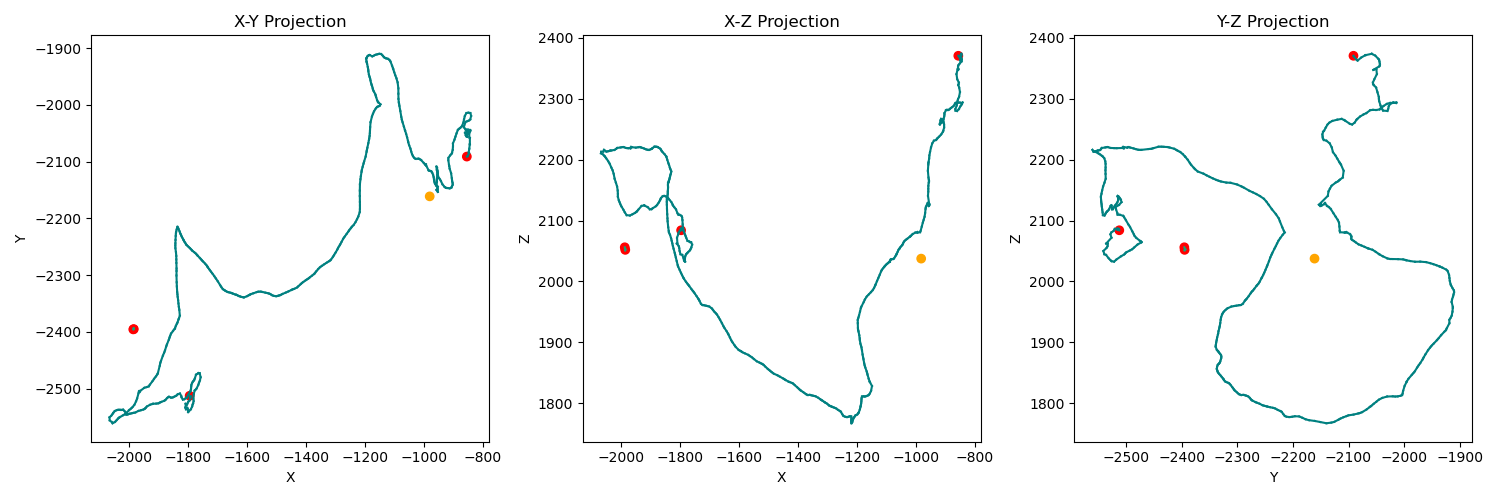

In [9]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [10]:
for i in connected_nodes:
    [print(connected_nodes[i])]

[1, 2]
[0, 3]
[5, 0]
[2, 6]
[4, 1]
[3, 8]
[5, 7]
[6, 10]
[9, 4]
[8, 11]
[9, 13]
[12, 7]
[10, 15]
[11, 14]
[13, 18]
[16, 12]
[15, 17]
[16, 19]
[21, 14]
[18, 23]
[20, 17]
[19, 22]
[20, 24]
[21, 30]
[22, 26]
[24, 25]
[26, 27]
[28, 25]
[27, 29]
[28, 31]
[32, 23]
[30, 34]
[29, 33]
[32, 41]
[35, 31]
[33, 42]
[37]
[36, 40]
[37, 38]
[39, 40]
[38]
[34, 43]
[35, 45]
[44, 41]
[43, 46]
[50, 42]
[45, 51]
[47, 44]
[46, 48]
[47, 49]
[48, 52]
[50, 53]
[51, 54]
[56, 49]
[52, 57]
[53, 55]
[54, 59]
[56, 58]
[57, 60]
[61, 55]
[59, 62]
[63, 58]
[60, 64]
[61, 65]
[66, 63]
[64, 67]
[68, 62]
[65, 70]
[66, 69]
[68, 73]
[71, 67]
[69, 72]
[70, 76]
[71, 74]
[75, 72]
[74, 77]
[75, 79]
[78, 73]
[76, 81]
[80, 77]
[79, 83]
[82, 78]
[81, 84]
[82, 85]
[86, 80]
[83, 87]
[84, 88]
[86, 89]
[90, 85]
[88, 92]
[87, 91]
[90, 106]
[93, 89]
[91, 94]
[93, 100]
[96, 97]
[95, 98]
[95, 101]
[96, 99]
[102, 98]
[99, 103]
[94, 113]
[104, 97]
[101, 105]
[102, 112]
[104, 107]
[105, 110]
[121, 92]
[106, 131]
[109, 111]
[108, 110]
[109, 1

In [14]:
# Get the track with the most nodes, this is taken to be the primary

num_nodes = 0
primary_track_id = -1
primary_nodes = []

for t in Tracks:
    if ( len(t["nodes"]) > num_nodes):
        num_nodes = len(t["nodes"])
        primary_track_id = t["id"]
        primary_nodes = t["nodes"]

print("The primary track is: ", primary_track_id)

# This list makes sure we only have one angle per node
all_visited = []

Primary_Track = data.reindex(primary_nodes)
Primary_Track = GetAnglesDF(Primary_Track, all_visited, 1, primary_track_id)
all_visited = all_visited + primary_nodes

df_angles = pd.DataFrame()
df_angles = pd.concat([df_angles, Primary_Track], ignore_index=True)

for t in Tracks:

    trk_nodes = t["nodes"]
    if t["id"] == primary_track_id:
        continue
    else:
        
        # See if the first/last node has three connections. If it does then flip the track
        con_end = connection_count[t["nodes"][-1]]
        if (con_end == 3):
            trk_nodes = trk_nodes[::-1]
        
        trk = data.reindex(trk_nodes)

        trk = GetAnglesDF(trk, all_visited, 0, t["id"])
        all_visited = all_visited + trk_nodes
        df_angles = pd.concat([df_angles, trk], ignore_index=True)


# Primary_Track.reset_index(drop=True, inplace=True)
pd.set_option('display.max_rows', 100)
display(df_angles[df_angles.trkID ==5])

print(connected_nodes)



The primary track is:  5


,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle
0,523,-1795.468872,-2512.603516,2084.121826,0.005475,162,1,5,0.000000,0.000000
1,523,-1793.571533,-2513.335449,2084.529785,0.011650,165,1,5,2.074139,135.876992
2,523,-1792.682739,-2513.297607,2086.194580,0.054950,166,1,5,3.961711,53.335415
3,523,-1793.964355,-2515.859375,2087.146973,0.027900,164,1,5,6.980361,86.483336
4,523,-1791.855713,-2515.043701,2084.812988,0.000550,169,1,5,10.229850,135.655083
...,...,...,...,...,...,...,...,...,...,...
512,523,-846.892883,-2077.353760,2367.724854,0.018975,512,1,5,3369.525399,72.995772
513,523,-849.019409,-2083.607422,2362.906006,0.007250,508,1,5,3377.701688,11.303780
514,523,-847.719421,-2085.229980,2363.861084,0.002400,510,1,5,3379.989665,81.453529
515,523,-852.904785,-2090.523193,2369.639893,0.069525,502,1,5,3389.386512,69.961716


{0: [1, 2], 1: [0, 3], 2: [5, 0], 5: [2, 6], 3: [4, 1], 4: [3, 8], 6: [5, 7], 7: [6, 10], 8: [9, 4], 9: [8, 11], 11: [9, 13], 10: [12, 7], 12: [10, 15], 13: [11, 14], 14: [13, 18], 15: [16, 12], 16: [15, 17], 17: [16, 19], 18: [21, 14], 21: [18, 23], 19: [20, 17], 20: [19, 22], 22: [20, 24], 23: [21, 30], 24: [22, 26], 26: [24, 25], 25: [26, 27], 27: [28, 25], 28: [27, 29], 29: [28, 31], 30: [32, 23], 32: [30, 34], 31: [29, 33], 34: [32, 41], 33: [35, 31], 35: [33, 42], 36: [37], 37: [36, 40], 40: [37, 38], 38: [39, 40], 39: [38], 41: [34, 43], 42: [35, 45], 43: [44, 41], 44: [43, 46], 45: [50, 42], 50: [45, 51], 46: [47, 44], 47: [46, 48], 48: [47, 49], 49: [48, 52], 51: [50, 53], 53: [51, 54], 52: [56, 49], 56: [52, 57], 54: [53, 55], 55: [54, 59], 57: [56, 58], 58: [57, 60], 59: [61, 55], 61: [59, 62], 60: [63, 58], 63: [60, 64], 62: [61, 65], 64: [66, 63], 66: [64, 67], 65: [68, 62], 68: [65, 70], 67: [66, 69], 70: [68, 73], 69: [71, 67], 71: [69, 72], 73: [70, 76], 72: [71, 74], 7

Text(0, 0.5, 'Scatter Angle [deg]')

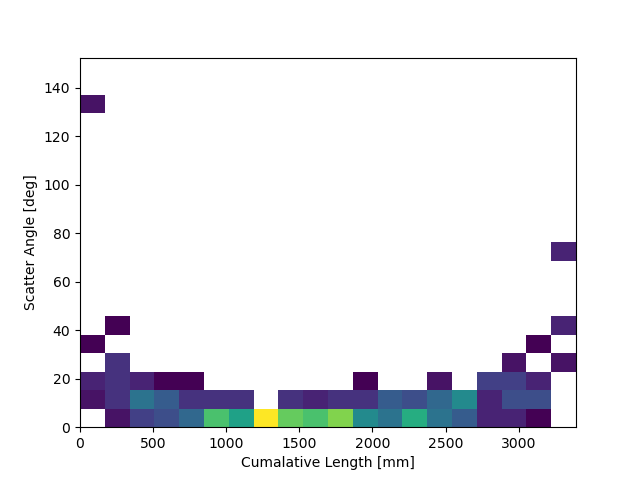

In [12]:
plt.figure()
# plt.scatter(Primary_Track.x, Primary_Track.z)

# plt.scatter(Primary_Track.index, Primary_Track.angle)

# plt.hist(Primary_Track.angle)
# plt.semilogy()
plt.hist2d(Primary_Track.cumulative_distance, Primary_Track.angle, bins = 20,cmin=3);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle)

plt.xlabel("Cumalative Length [mm]")
plt.ylabel("Scatter Angle [deg]")

KeyError: 36

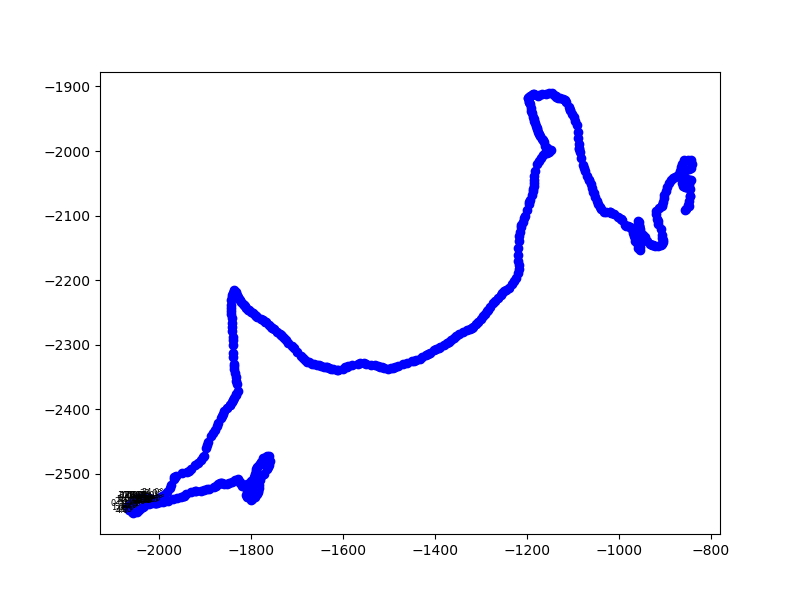

In [13]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Primary_Track['x'], Primary_Track['y'], color='blue', label='Points')

# Annotate each point with the corresponding angle
for i in range(len(Primary_Track)):
    x = Primary_Track.loc[i, 'x']
    y = Primary_Track.loc[i, 'y']
    # angle = Primary_Track.loc[i, 'angle']
    angle = i
    
    # Only annotate if angle is not NaN
    if not np.isnan(angle):
        plt.text(x, y, f'{angle:.1f}°', fontsize=6, ha='right')

# Additional plot settings
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of X, Y with Angle Annotations')
plt.legend()
plt.grid(True)

# Show plot
plt.show()